# Importing libraries

In [1]:
!pip install pyldavis
!pip install --ignore-installed spark-nlp==2.3.1
!pip install bokeh
!pip install nltk
!pip install pandas
import nltk
nltk.download('stopwords')

nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

nltk.download('vader_lexicon')
!pip install geopy



from pyspark.sql.functions import lit, when, col, regexp_extract,lower 
from geopy.geocoders import Nominatim
import geopy.geocoders
import pandas as pd

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os
# from functools import reduce
import json
import time

from pyspark.sql import SQLContext, Row
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import HiveContext, Row
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col,regexp_replace

import re;
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import string
import pyspark.sql.functions as f
from nltk.stem import WordNetLemmatizer
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
##LDA specific imports and installs


from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import explode,size

import pyLDAvis
import numpy as np

  Using cached https://files.pythonhosted.org/packages/c2/e0/c036825e5e5f272b51835a1cf1ed9c871dd520009ca64039c3a401c1df23/spark_nlp-2.3.1-py2.py3-none-any.whl


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/umarajpotla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/umarajpotla/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/umarajpotla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/umarajpotla/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Library/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# Spark Session

In [2]:
spark = SparkSession.builder.master("local[*]").appName("BDP_Proj").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

dataf1 = spark.read.option("header",True).option("escape","\"").csv("SparkAllRetweets.csv")
dataf2 = spark.read.option("header",True).option("escape","\"").csv("SparkAllTweets.csv")

dataf=(dataf1.drop('retweeted_id')).union(dataf2)
dataf

DataFrame[_c0: string, created_at: string, id: string, text: string, source: string, user: string, geo: string, coordinates: string, place: string, retweet_count: string, favorite_count: string, entities: string, lang: string]

# Function Definitions

In [20]:
import nltk;
import string

def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)


def remove_stopwords(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    stop_words.add("rt")
    filtered_sentence = [w for w in x if not w in stop_words]
    return filtered_sentence



def remove_punctuations(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered_space

def lemmatization(x):
    lemmatizer_model = WordNetLemmatizer()
    final_Lem = [lemmatizer_model.lemmatize(s) for s in x]
    return final_Lem

def join_tokens(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x


def sentiment_words(x):
    
    #making a model
    sentiment_analyzer = SentimentIntensityAnalyzer() 
    
    #Analysing the polarity scores
    sentiment_list_temp = []
    for i in x[:-1]:
        temp_list = ''.join(i) 
        polarity_score = sentiment_analyzer.polarity_scores(temp_list)
        sentiment_list_temp.append((temp_list, polarity_score))
        sentiment_list_temp = [w for w in sentiment_list_temp if w]
    
    #Assignment of the polarity score value
    sentiment_list  = []
    for i in sentiment_list_temp:
        text = i[0]
        second = i[1]
        total_neg=[]
        total_pos=[]
        for (norm_Score, v) in second.items():
            if norm_Score == 'compound':
                if v < 0.0:
                    sentiment_list.append((text,"Negative",v*100,x[-1:]))
                    total_neg.append(v*100)
                   
                elif v == 0.0:
                    sentiment_list.append((text,"Neutral",v*100,x[-1:]))
                    
                else:
                    sentiment_list.append((text,"Positive",v*100,x[-1:]))
                    total_pos.append(v*100)
    
    
    return sentiment_list


#Extraction of phrases for performing Sentiment Analysis
def extract_phrases(x):
    stop_words=set(stopwords.words('english'))
    stop_words.add("rt")
    
    #making tokens from words
    sentence_regex = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    tokens = nltk.regexp_tokenize(x[0],sentence_regex)
    
    #Tagging parts of speech to every token generated
    pos_tokens = nltk.tag.pos_tag(tokens) 
    
    #performing the chunks using nouns and adjectives
    grammar = r"""
    NP_GRAMMAR:
        {<NN.*|JJ>*<NN.*>}
        {<NN.*|JJ>*<NN.*><IN><NN.*|JJ>*<NN.*>}  
    """
    chunker = nltk.RegexpParser(grammar)
    
    #Making a chunk tree from Parts of Speech tokens
    chunk_tree = chunker.parse(pos_tokens) 
    
    #Finding Noun Phrases (GRAMMAR) from leaf nodes of a chunk tree
    def tree_leaves(tree):
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP_GRAMMAR'):
            yield subtree.leaves()
    
    #getting a leaf from the chunk tree
    def get_terms(tree):
        for leaf in tree_leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
            
    terms = get_terms(chunk_tree)
    
    
    #making pharses out of the terms
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    temp_phrases.append(x[1])
    
    #remove empty lines
    final_Phrase = [w for w in temp_phrases if w] 
    
    return final_Phrase

#to remove null which were coming after the extraction
def blank_as_null(x):
    return when(col(x) != "", col(x)).otherwise(None)



# Why PokemonGo ? Comaprison with other applications

Why we choose Pokemon Go and how it is one of the major events in 2016.

We have to analyze the popularity of pokemon GO. First, we will be doing data preprocessing using data mining techniques. Then by using the attributes, we have as part of the JSON file, we will find the relations of the game with some other events that we had in 2016. Data segregation can be done on the basis of hashtags present in the data. The insights will represent some most talked-about events in 2016 on Twitter.

In [4]:
#removing the null and then transforming Spark data frame to rdd 
textOnlydf=dataf.select("text").dropna()
textOnlyRdd = textOnlydf.rdd.map(str)

#filter every thing which is in english
filteredtextdf=textOnlydf.withColumn('FilteredText', F.regexp_replace('text',r'([^A-Za-z \t])|(\w+:\/\/\S+)', ''))
textOnlyRdd = filteredtextdf.select("FilteredText").rdd.map(str)

#to split and count get the word count
counts = textOnlyRdd.flatMap(lambda line: line.lower().split())\
    .map(lambda word: (word, 1))\
    .reduceByKey(lambda x, y: x + y)
    
    
#Converting the word count back to Spark data fram
distinctwordsdf=counts.toDF()
distinctwordsdf=distinctwordsdf.withColumnRenamed('_1', 'word')
distinctwordsdf=distinctwordsdf.withColumnRenamed('_2', 'count')

#adding famous apps from wikipedia and filterign the dataframe 

AppList =['pokémongo','pokemon','pokecoins','poké',
          'poke','pokmon','pokémonsunandmoon','pokemonsunandmoon','twitter','facebook','tinder','snapchat','amazon']

finalPlotdf=distinctwordsdf.where(col("word").\
isin(AppList)).withColumn('word', regexp_replace(col('word') , r'pok[A-Za-z]*', 'PokemonGO' ))\
    .groupBy('word').sum().sort('sum(count)', ascending=False)
    


GameList =['pokémongo','pokemon','pokecoins','poké',
          'poke','pokmon','pokémonsunandmoon','pokemonsunandmoon','clash','clashland','reigns','renegade','Asphalt','Pinout','sudoku','mario','Dues']

finalPlotdf1=distinctwordsdf.where(col("word").\
isin(GameList)).withColumn('word', regexp_replace(col('word') , r'pok[A-Za-z]*', 'PokemonGO' ))\
    .groupBy('word').sum().sort('sum(count)', ascending=False)

finalPlotdf2=finalPlotdf1.withColumn('word', regexp_replace(col('word') , r'clash[A-Za-z]*', 'ClashRoyal' ))\
    .groupBy('word').sum().sort('sum(sum(count))', ascending=False)

#renaming the last column 
finalPlotdf1=finalPlotdf1.withColumnRenamed('sum(count)', 'count')
finalPlotdf2=finalPlotdf2.withColumnRenamed('sum(sum(count))','count')

finalPlotdf2.toPandas().to_csv("mobile_games.csv",header=True)
finalPlotdf.toPandas().to_csv("All_Apps.csv",header=True)

We are using pygal an external library to plot the data.<BR>
It brings it intuitive nature using predefined JS

In [5]:
finalPlotPandf=finalPlotdf.toPandas()
import pygal
from pygal.style import Style
import pygal
from ipywidgets import HTML
from IPython.display import HTML
import base64

custom_style = Style(
  olors=('#E853A0', '#E8537A', '#E95355', '#E87653', '#E89B53'))

b_chart = pygal.Bar(style=custom_style,width=1000, height=400, explicit_size=True)
b_chart.title = "Applications that most people tweeted, In 2016"

for bar in range(len(finalPlotPandf)):
    b_chart.add(finalPlotPandf['word'].iloc[bar],finalPlotPandf['sum(count)'].iloc[bar])

%matplotlib inline
from IPython.display import SVG, HTML

html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
             <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
              <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=b_chart.render(is_unicode=True)))

We are using pygal an external library to plot the data.<BR>
It brings it intuitive nature using predefined JS

In [6]:
finalPlotdf2Pandf=finalPlotdf2.toPandas()
import pygal
from pygal.style import Style
import pygal
from ipywidgets import HTML
from IPython.display import HTML
import base64

custom_style = Style(
  olors=('#E853A0', '#E8537A', '#E95355', '#E87653', '#E89B53'))

b_chart = pygal.Bar(style=custom_style,width=1000, height=400, explicit_size=True)
b_chart.title = "Mobile Gaming Applications that most people tweeted, In 2016"

for bar in range(len(finalPlotdf2Pandf)):
    b_chart.add(finalPlotdf2Pandf['word'].iloc[bar],finalPlotdf2Pandf['count'].iloc[bar])

%matplotlib inline
from IPython.display import SVG, HTML


html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
             <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
              <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=b_chart.render(is_unicode=True)))

# Analyisng popularity of Pokemon GO across the world

The popularity of PokemonGo has been global; it is used by plenty of people spread across the world. Using this fact,
we can visualize the trends of PokemonGo based on the GeoLocation. Twitter data provides location information. From
the location information, we can derive the various insights. For example, we can determine the popularity of PokemonGo based on the location. We will use various graphical methods for representation of the same.

In [7]:

#to remove null which were coming after the extraction
def blank_as_null(x):
    return when(col(x) != "", col(x)).otherwise(None)

#get coordinates from
# dataf1 = spark.read.option("header",True).option("escape","\"").csv("translated_pokemon_tweets.csv")
# dataf2 = spark.read.option("header",True).option("escape","\"").csv("translated_pokemon_retweets.csv")

# dataf=(dataf1.drop('retweeted_id')).union(dataf2)
coor= dataf.select("coordinates")

locationCoord=coor.filter("coordinates not like '0' and coordinates like 'Row(coordinates=%' and coordinates not like '%Polygon%'")

#filtering coordinates and splitting latituded and longitudes and then storing them in finalGeoLocation
expr = r'\[(.*?)\]+'
# filter on the basis of the coordinate formates
geo_locations = locationCoord.filter(locationCoord["coordinates"].rlike(expr))

# keeping only the required data ---- we need to check this
new_df = geo_locations.select(regexp_extract('coordinates', r'\[(.*?)\]+', 1).alias('extracted'))

#drop null
dfWithEmptyReplaced = new_df.withColumn("extracted_coordinates", blank_as_null("extracted"))

#remove  na
finalGeoLocation=dfWithEmptyReplaced.na.drop()

finalGeoLocation=finalGeoLocation.toPandas()
finalGeoLocation[['long','lat']]=finalGeoLocation.extracted_coordinates.str.split(",",expand=True)

#Converting all the coordinates in to exact format of latitude and longitude

finalGeoLocation['long'] = finalGeoLocation['long'].apply(lambda x: x.replace("[", ""))  
finalGeoLocation['long'] = finalGeoLocation['long'].apply(lambda x: float(x))
finalGeoLocation['lat'] = finalGeoLocation['lat'].apply(lambda x: float(x))
finalGeoLocation['long']=finalGeoLocation['long'].round(decimals=6)
finalGeoLocation['lat']=finalGeoLocation['lat'].round(decimals=6)

#Calling geopy and fetching countries from the coordinated
geopy.geocoders.options.default_timeout = 1000000
geolocator = Nominatim(user_agent="AnitGeoCode")
coutrydata=[]
for i in range(len(finalGeoLocation)):
    cordinates=str(finalGeoLocation['lat'].iloc[i])+","+str(finalGeoLocation['long'].iloc[i])
    location = geolocator.reverse(cordinates)
    lat=finalGeoLocation['lat'].iloc[i]
    long=finalGeoLocation['long'].iloc[i]
    country=location.raw['address']['country']
    #making a dictionary to and append in the list in order to push them to a data frame
    coutrydata.append({"coordinates":cordinates,"country":country,"latitude":lat,"longitude":long})



countryDatadf=pd.DataFrame(coutrydata)


countryDatadf.to_csv('coordinates_final.csv')
countryDatadf.head()



,coordinates,country,latitude,longitude
0,"7.081874,125.505375",Philippines,7.081874,125.505375
1,"23.7867,73.5231",India,23.786700,73.523100
2,"37.782112,-122.400613",United States of America,37.782112,-122.400613
3,"40.671743,-73.953282",United States of America,40.671743,-73.953282
4,"40.926841,29.123982",Türkiye,40.926841,29.123982


In [23]:
import plotly.graph_objects as go
#conda install -c plotly/label/test plotly
import seaborn as sns

fig = go.Figure(data=go.Scattergeo(
        lon = countryDatadf['longitude'],
        lat = countryDatadf['latitude'],
        text = countryDatadf['country'],
        mode = 'markers',
        marker_color ="purple",
        ))

fig.update_layout(
        title = 'Pokemons Usage across the world<br>',
        geo_scope='world',
    )


fig.show()

# Sentiment Analysis On tweets "text " fields and finding polarities
Pokemon Go game received both positive and negative
feedback related to the implementation using AR in this field,
its vivid use, and technical glitches that the application had.
Users tweeted related to PokemonGO with their opinions
towards the game. As part of sentiment analysis, we will
be analyzing the user’s take over the game. Although a
tweet is a simple text with limited characters, people express
their opinions precisely through hashtags. So based on those
valuable hashtags, we would like to categorize the tweets into
positive, neutral and negative. While computing the overall
polarity of the game, we will be considering the level of
positivity and negativity of the tweets.

In [21]:
import re;
from pyspark.sql import functions as F

sentimentAnalysisText = dataf.select("text","created_at","user")
null_columns_count_list_sa = null_value_count(sentimentAnalysisText)
spark.createDataFrame(null_columns_count_list_sa, ['Column_With_Null_Value', 'Null_Values_Count'])#.show()


sentimentAnalysisText = sentimentAnalysisText.dropna()
sentimentAnalysisText = sentimentAnalysisText.withColumn("only_str",regexp_replace(col('text'), '\d+', ''))
sentimentAnalysisText = sentimentAnalysisText.withColumn('value', F.regexp_replace('text', '([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ''))
sentimentAnalysisText =  sentimentAnalysisText[sentimentAnalysisText['text'].contains("pok")]
dataf_sa = sentimentAnalysisText.select("value","created_at")
dataf_sa.show(2)

<>:10: DeprecationWarning:

invalid escape sequence \d

<>:11: DeprecationWarning:

invalid escape sequence \w

<>:10: DeprecationWarning:

invalid escape sequence \d

<>:11: DeprecationWarning:

invalid escape sequence \w

<>:10: DeprecationWarning:

invalid escape sequence \d

<>:11: DeprecationWarning:

invalid escape sequence \w

<ipython-input-21-792a8cf85cd8>:10: DeprecationWarning:

invalid escape sequence \d

<ipython-input-21-792a8cf85cd8>:11: DeprecationWarning:

invalid escape sequence \w



+--------------------+--------------------+
|               value|          created_at|
+--------------------+--------------------+
|RT OdinYT FolagoR...|Fri Oct 14 15:00:...|
|RT FeelzHurter Wh...|Fri Oct 14 15:00:...|
+--------------------+--------------------+
only showing top 2 rows



In [22]:
!pip install nltk
import nltk
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover


regex_tokenizer = RegexTokenizer(inputCol="value", outputCol="words", pattern="\\W")
raw_words_pokemon = regex_tokenizer.transform(dataf_sa)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
pokemon_words_df = remover.transform(raw_words_pokemon)


pokemon_words = pokemon_words_df.select("filtered").rdd.flatMap(lambda x: x)
stopwordRDD_pokemon = pokemon_words.map(remove_stopwords)

rmvPunctRDD_pokemon = stopwordRDD_pokemon.map(remove_punctuations)

lem_wordsRDD_pokemon = rmvPunctRDD_pokemon.map(lemmatization)

joinedTokens_pokemon = lem_wordsRDD_pokemon.map(join_tokens)



#convert joinedTokens to DataFrame add date column and text column and convert back to rdd
df_pokemon = joinedTokens_pokemon.map(lambda x: (x, )).toDF()
df_pokemon = df_pokemon.withColumn('row_index', f.monotonically_increasing_id())
sentimentAnalysisText = sentimentAnalysisText.withColumn('row_index', f.monotonically_increasing_id())
jointokendf_pokemon = df_pokemon.join(sentimentAnalysisText, on=["row_index"]).sort("row_index").drop("row_index")
jointokendf_pokemon = jointokendf_pokemon.selectExpr("_1 as text", "created_at as Date")
jointokenrdd = jointokendf_pokemon.rdd.map(list)


newrdd=jointokenrdd.map(extract_phrases)
#applying Sentiment Analysis
sentimentRDD= newrdd.map(sentiment_words)

#Removing empty list
sentimentRDD1=sentimentRDD.map(lambda x : None if (x==[]) else x)

#removing Nones
sentimentRDD2=sentimentRDD1.filter(lambda x: x is not None)

#Mapping Text,Sentiment,Parity Value and the Date
sentimentRDD3 = sentimentRDD2.map(lambda x: (x[0][0],x[0][1],x[0][2],x[0][3][0]))

print(sentimentRDD3.take(5))

#write to an CSV file for us to leverage Tableau 
Fileout = open("FinalSentimentScore.csv","w")
Fileout.write("Text_phrase,Sentiment,Parity,DateTime\n")
for line in sentimentRDD3.collect() :
    Fileout.write(','.join(str(var) for var in line))
    Fileout.write('\n')

print('\nThe data is successfully exported to the file :',Fileout.name)
Fileout.close()

[('odinyt folagor portaventuraes subes tan alto que va al cielo donde estn tus', 'Neutral', 0.0, 'Fri Oct 14 15:00:25 +0000 2016'), ('live jersey mountain dont', 'Neutral', 0.0, 'Fri Oct 14 15:00:31 +0000 2016'), ('bignarstie fuck shud pokemon halloween', 'Negative', -54.230000000000004, 'Sat Oct 29 15:00:17 +0000 2016'), ('morvantcheryl leak clinton spokesperson', 'Negative', -34.0, 'Thu Oct 13 15:04:27 +0000 2016'), ('athlyte le gar dpense', 'Neutral', 0.0, 'Thu Oct 20 14:15:08 +0000 2016')]

The data is successfully exported to the file : FinalSentimentScore.csv


# LDA - Topic Modeling, An unsupervised classification

In what context is Pokemon GO being used in and how are ´
the app users speaking of this game? Using Latent Dirichlet
Allocation (LDA) algorithm, we shall use topic modeling
to further understand the context in which Pokemon GO ´
is being tweeted about. Topic modeling is a method for
unsupervised classification of documents or text to find natural
groupings called “topics” even when the characteristics of each
topic is unknown. The main approach for this is to select k
number of topics for the algorithm, apply the algorithm to
twitter data using the hashtag pokemongo, and analyze the
features of the topics such as most frequent words used in
each topic to find a real-life meaning for each topic. For each
topic, we would also like to find the number of tweets within
this topic to understand which topics are the most popular.
This type of analysis could be useful to improve the game or
help understand the mass appeal of the app.

In [ ]:
##uses data frame from SA, filters on 'pok' to get pokemon tweets
# and additional text cleaning and tokenization
#some cleaning may be redone
datalda=dataf.filter(dataf.lang=='en')
tweets=datalda.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
#filtering on pok,pokemon,
tokens = tweets                                                   \
    .map( lambda document: " ".join(re.findall('[A-Z][^A-Z]*',document)))               \
    .filter( lambda document: 'pokemon' in document.lower())               \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.sub('pokemon', ' ', document))          \
    .map( lambda document: re.sub('pokmon', ' ', document))          \
    .map( lambda document: re.sub('https', ' ', document))          \
    .map( lambda document: re.sub('\W+', ' ', document))          \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 2] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .filter(lambda x: x !=[])        \
    .zipWithIndex()

In [ ]:
##tf-idf vectors
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])
df = df_txts.filter(df_txts.list_of_words. isNotNull())
# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=10000)#, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [ ]:
##Fitting Model
num_topics = 4
lda = LDA(k=num_topics, seed=1, optimizer="em")
lda_model = lda.fit(result_tfidf[['index','features']])
transformed = lda_model.transform(result_tfidf)

In [ ]:
###creates data in correct format to plot using pyLDAvis bubble chart from fitted LDA model
def format_data_to_pyldavis(df, count_vectorizer, transformed, lda_model):
    x = df.select((explode(df.list_of_words)).alias("words")).groupby("words").count()
    word_counts = {r['words']:r['count'] for r in x.collect()}
    word_counts = [word_counts[w] for w in count_vectorizer.vocabulary]


    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
            'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
            'doc_lengths': [r[0] for r in df.select(size(df.list_of_words)).collect()],
            'vocab': count_vectorizer.vocabulary,
            'term_frequency': word_counts}

    return data

###filters out tweets where topics probability equals 0
def filter_bad_tweets(data):
    bad = 0
    doc_topic_dists_filtered = []
    doc_lengths_filtered = []

    for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
        if np.sum(x)==0:
            bad+=1
        elif np.sum(x) != 1:
            bad+=1
        elif np.isnan(x).any():
            bad+=1
        else:
            doc_topic_dists_filtered.append(x)
            doc_lengths_filtered.append(y)

    data['doc_topic_dists'] = doc_topic_dists_filtered
    data['doc_lengths'] = doc_lengths_filtered

data = format_data_to_pyldavis(df, cvmodel, transformed, lda_model)
filter_bad_tweets(data)

py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

# Pokemon Facts - Rarity of Pokemons & Future Prediction(Time Series Analysis
Pokemon character they caught and the scores along
with screenshot images of the Pokemon. In this study, one of
our goals is to analyze the most frequent Pokemon tweeted
through the most rarest Pokemon caught and tweeted about.
We would be analyzing this task using visualizations and
graphs either by the python libraries or tableau.

In [24]:
# Pokemon characters data
pokemonCharsdata = spark.read.csv('PokemonCharacters.csv',inferSchema=True, header=True)

pokemonChars_rdd = pokemonCharsdata.select("Pokemons").rdd.flatMap(lambda x: x)
#convert all strings to lower case and to list
pokemonList = pokemonChars_rdd.map(lambda x: x.lower()).collect()

commonCharsRDD = stopwordRDD_pokemon.map(lambda word: [x for x in word if x in pokemonList]).filter(lambda x: x!=[])
commonCharsRDD1 = commonCharsRDD.flatMap(lambda x: x) # flat map for getting each string 
commonCharsRDD2 = commonCharsRDD1.map(lambda x: (x,1)) # assign 1 count for each string
commonCharsCount = commonCharsRDD2.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False) # group by key

commonCharsCount.collect()

pokemonCharsCountDf = commonCharsCount.toDF()

pokemonCharsCountDfPandas = pokemonCharsCountDf.toPandas()

pokemonCharsCountDf.write.mode('overwrite').csv("pokemonCharsCount")

In [25]:
!pip install pygal

import pygal
from pygal.style import Style
import pygal
from ipywidgets import HTML
from IPython.display import HTML
import base64

custom_style = Style(
  olors=('#E853A0', '#E8537A', '#E95355', '#E87653', '#E89B53'))

b_chart_pokemonFreq = pygal.Bar(style=custom_style,width=1000, height=400, explicit_size=True)
b_chart_pokemonFreq.title = "10 Most Frequent Pokemon Charcaters Tweeted"

for bar in range(len(pokemonCharsCountDfPandas.head(10))):
    b_chart_pokemonFreq.add(pokemonCharsCountDfPandas['_1'].iloc[bar], pokemonCharsCountDfPandas['_2'].iloc[bar])


from IPython.display import SVG, HTML

"""b64 = base64.b64encode(b_chart.render())
src = 'data:image/svg+xml;charset=utf-8;base64,'+(b64)
HTML('<embed src={}></embed>'.format(src))"""
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
             <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
              <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render = b_chart_pokemonFreq.render(is_unicode=True)))

In [26]:
b_chart_pokemonFreq1 = pygal.Bar(style=custom_style,width=1000, height=400, explicit_size=True)
b_chart_pokemonFreq1.title = "10 Rarest Pokemon Characters Tweeted"
rarestPokemonsDf1 = pokemonCharsCountDfPandas.iloc[-10:]
for bar in range(len(rarestPokemonsDf1)):
    b_chart_pokemonFreq1.add(rarestPokemonsDf1['_1'].iloc[bar], rarestPokemonsDf1['_2'].iloc[bar])
    
HTML(html_pygal.format(pygal_render = b_chart_pokemonFreq1.render(is_unicode=True)))

# TIME SERIES ANALYSIS

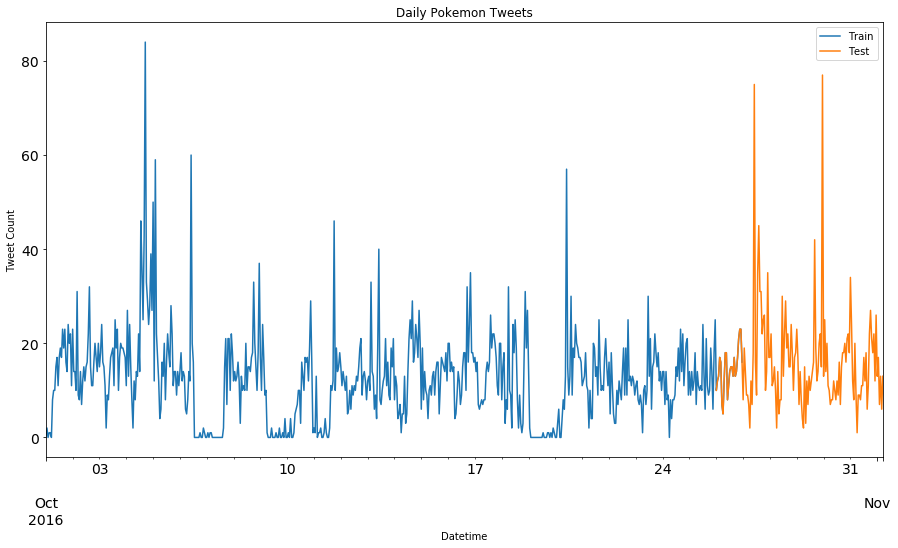

In [27]:
# Get Created At timestamp data from Poekon Tweets and drop nulls
createdAtDf = sentimentAnalysisText.select("created_at")
createdAtDf = createdAtDf.dropna()
from datetime import datetime

createdAtPandasDf = createdAtDf.toPandas()
createdAtPandasDf = createdAtPandasDf.iloc[:-1]

# Remove unnecessary row
createdAtPandasDf['created_at'] = createdAtPandasDf[createdAtPandasDf['created_at']!=' poketesecuestran']
# Format Datetime from created_at
createdAtPandasDf['datetime'] = pd.to_datetime(createdAtPandasDf.created_at, format = '%a %b %d %H:%M:%S %z %Y')
# Format date time to DD-MM-YYYY HH:mm format for Time Series Analysis
createdAtPandasDf['datetime_new'] = createdAtPandasDf['datetime'].dt.strftime('%d-%m-%Y %H:%M')
# get Datetime data to Timestamp format 
train=createdAtPandasDf['datetime_new']
train.Timestamp = pd.to_datetime(createdAtPandasDf.datetime_new, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

#Get Pokemon Tweets counts on Hourly basis
train = train.resample('H').count()
# Get Training and Testing data
fig, ax = plt.subplots(figsize=(13,7))
Train = train.loc['2016-10-01':'2016-10-26']
test = train.loc['2016-10-26':'2016-11-01']
Train.plot(figsize = (15,8), title = 'Daily Pokemon Tweets', fontsize = 14, label = 'Train')
test.plot(figsize = (15,8), title = 'Daily Pokemon Tweets', fontsize =14, label = 'Test')
plt.xlabel('Datetime')
plt.ylabel('Tweet Count')
plt.legend(loc = 'best')
plt.show()


# Taking log values of Train & Test data
Train_log = np.log(Train)
test_log = np.log(test)

# Dropping inf and na values
Train_log = Train_log[~np.isinf(Train_log)]

# SARIMAX Model

References:
1. https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
2. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
3. https://medium.com/@rrfd/sarima-modelling-for-car-sharing-basic-data-pipelines-applications-with-python-pt-1-75de4677c0cd
4. https://ashwin-ks.github.io/2018-05-02-Time-Series-Modelling-using-Python/

/Library/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Library/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                 
Dep. Variable:                       datetime_new   No. Observations:                  624
Model:             SARIMAX(4, 1, 1)x(2, 1, 1, 24)   Log Likelihood               -2077.756
Date:                            Mon, 09 Dec 2019   AIC                           4173.511
Time:                                    00:33:54   BIC                           4213.069
Sample:                                10-01-2016   HQIC                          4188.911
                                     - 10-26-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2854      0.034      8.367      0.000       0.219       0.352
ar.L2          0.1958      0.034   

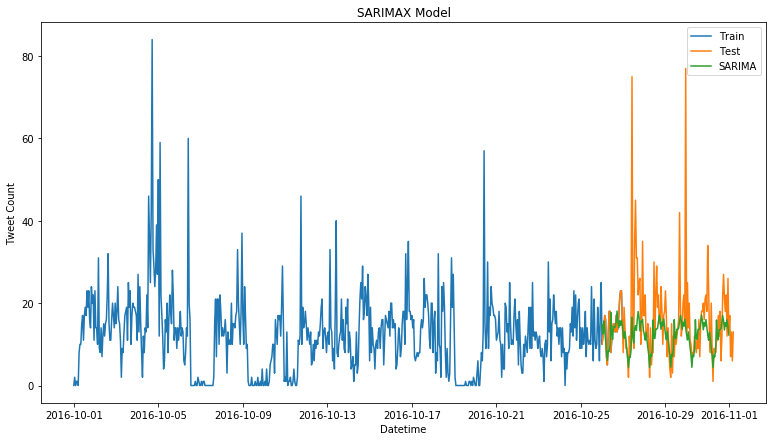

In [28]:
import statsmodels.api as sm
y_hat_avg = test.copy()

# fit SARIMAX model with seasonal order of 24 hrs
fit1 = sm.tsa.statespace.SARIMAX(Train, order = (4,1,1), seasonal_order =(2,1,1,24)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2016-10-26", end="2016-11-01", dynamic=True)
print(fit1.summary())

fig, ax = plt.subplots(figsize=(13,7))
plt.plot(Train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(y_hat_avg['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.title("SARIMAX Model")
plt.xlabel('Datetime')
plt.ylabel('Tweet Count')
plt.show()

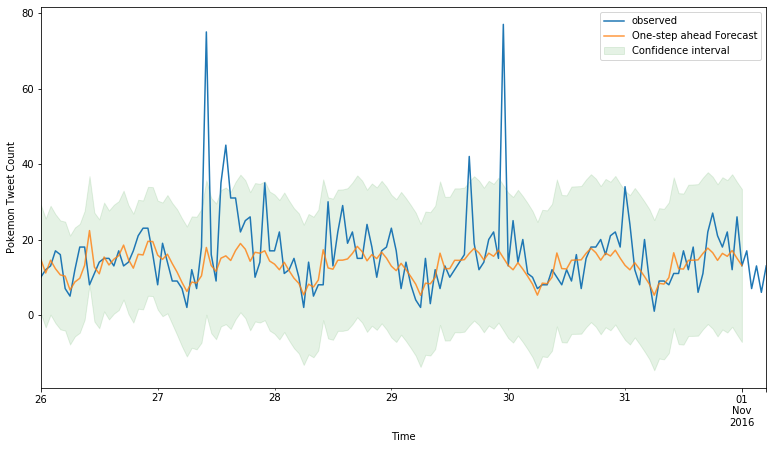

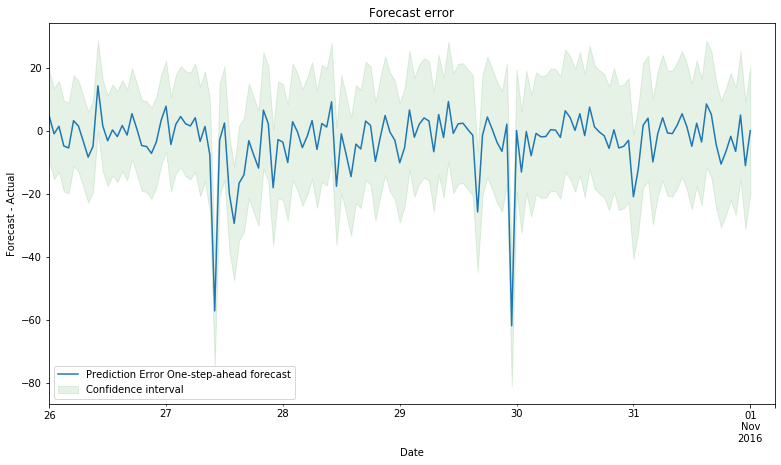

In [29]:
# Get Predictions
fig, ax = plt.subplots(figsize=(13,7))
pred = fit1.get_prediction(start="2016-10-26", end="2016-11-01", dynamic=False) # start and end dates of test data
pred_ci = pred.conf_int() # confidence intervals of predicted model

ax = test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.8)


ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='g', alpha=0.1, label='Confidence interval') # adding confidence intervals

legend = ax.legend(loc='lower right')

ax.set_xlabel('Time')
ax.set_ylabel('Pokemon Tweet Count')
plt.legend()

plt.show()


# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(13,7))
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

predict_error = pred.predicted_mean - test
predict_error.plot(ax=ax, label='Prediction Error One-step-ahead forecast')
ci = pred_ci.copy()
ci.iloc[:,0] -= test
ci.iloc[:,1] -= test
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1, color='g', label='Confidence interval')

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

In [35]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'Mean Absolute Percentage Error (MAPE)':mape,
            'Mean Error (ME)':me,
            'Mean Absolute Error (MAE)': mae, 
            'Mean Percentage Error (MPE)': mpe,
            'Root Mean Squared Error (RMSE)':rmse,  
            'Correlation between the Actual and the Forecast (corr)':corr,
            'Min-Max Error (minmax)':minmax})

forecast_accuracy(pred.predicted_mean, test[:145].values)

{'Mean Absolute Percentage Error (MAPE)': 0.39347628883985236,
 'Mean Error (ME)': -2.748887281490209,
 'Mean Absolute Error (MAE)': 5.706124549674806,
 'Mean Percentage Error (MPE)': 0.07207168796080622,
 'Root Mean Squared Error (RMSE)': 9.866293818645284,
 'Correlation between the Actual and the Forecast (corr)': 0.4134771290686682,
 'Min-Max Error (minmax)': 0.2771540645967224}